In [1]:
import numpy as np
import scipy.fft
import matplotlib.pyplot as plt

# Part 1 : Modeling the Environment

In [556]:
# Source freq
f_source = 200 #/s

# Interferer freq
f_int = 1000 #/s

# For both wave
c = 343 # m/s
T = 0.1 #s
fs = 100*max(f_source,f_int)
dL = 0.018
print('Spacing:',dL,'m')

# Time axis
taxis = 1/fs * np.arange(int(T*fs))
print('# of time points:',taxis.shape[0])

Spacing: 0.018 m
# of time points: 10000


In [579]:
# The spacial property of two sources
theta_1 = 0 # degrees
theta_2 = 90 # degrees

In [580]:
# About linear array
M = 10
ref_ch = 0 # Reference channel for RTF

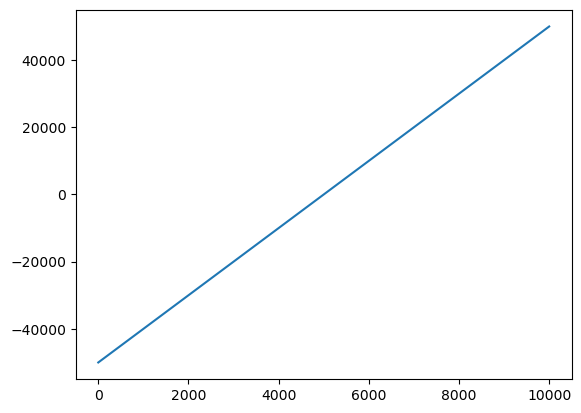

In [581]:
# System parameter
Nfft = taxis.shape[0]
faxis = scipy.fft.fftfreq(n=Nfft,d=1/fs) 
plt.plot(scipy.fft.fftshift(faxis))

# Part 2: ApplyRTF

In [582]:
def RTF_gen(theta,M,faxis,c,dL,ref_ch):
    
    # Output of (M,F)
    channels = [np.exp(-1j*2*np.pi*faxis/c*dL*(m+1)*np.cos(np.deg2rad(theta))) for m in range(M)]
    channels = [(ch/channels[ref_ch]) for ch in channels]
    
    return channels
    


rtf_source = RTF_gen(theta_1,M,faxis,c,dL,ref_ch) 
rtf_inter = RTF_gen(theta_2,M,faxis,c,dL,ref_ch) 

Text(0.5, 1.0, 'RTF Phase')

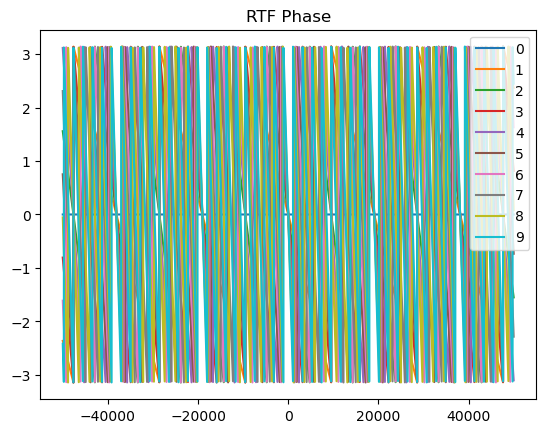

In [583]:
_ = [plt.plot(scipy.fft.fftshift(faxis),scipy.fft.fftshift(np.angle(rtf_source[m])),label=f'{m}') for m in range(M)]
plt.legend([f'{m}' for m in range(M)])
plt.title('RTF Phase')

Text(0.5, 1.0, 'RTF Real')

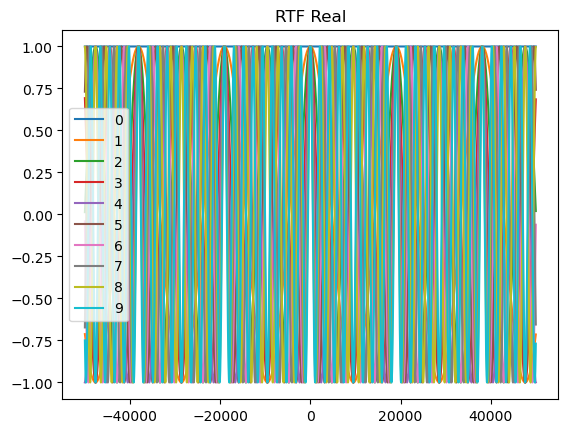

In [584]:
_ = [plt.plot(scipy.fft.fftshift(faxis),scipy.fft.fftshift(np.real(rtf_source[m])),label=f'{m}') for m in range(M)]
plt.legend([f'{m}' for m in range(M)])
plt.title('RTF Real')

In [585]:
# This is where we can apply RTF to generate multiple channels

def apply_RTF(x,RTF,N):
    
    Fx = scipy.fft.fft(x,N)
    Fy = [Fx * r for r in RTF]
    
    # return in frequency domain
    return Fy


s = 10*np.cos(2*np.pi*f_source*taxis)
i = 0.5*np.cos(2*np.pi*f_int*taxis)

Ys = apply_RTF(s,rtf_source,taxis.shape[0])
Yi = apply_RTF(i,rtf_inter,taxis.shape[0])

Y = [ys for yi,ys in zip(Ys,Yi)]

Text(0.5, 1.0, 'Channel Signals ys + n')

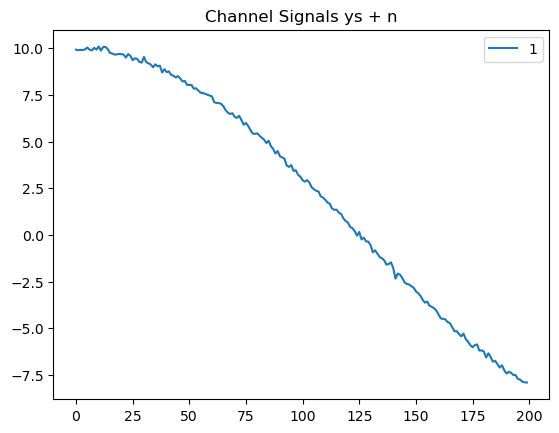

In [586]:
# Convert to time domain
channel_s = [np.real(scipy.fft.ifft(Ys[m],taxis.shape[0])) for m in range(M)]
channel_i = [np.real(scipy.fft.ifft(Yi[m],taxis.shape[0])) for m in range(M)]
channel_y = [np.real(scipy.fft.ifft(Y[m],taxis.shape[0])) for m in range(M)]

# Add noise in time domain
sig = 1e-1
N_cov = sig * np.identity(M) #Noise Covariance!! 

channel_y = [channel_s[m] + np.random.normal(loc=0,scale=N_cov[m,m],size=channel_y[m].shape) for m in range(M)]

#plot the signals
plt.plot(channel_y[0][:200],label='1')
#plt.plot(channel_y[1][:200],label='2')
#plt.plot(channel_y[2][:200],label='3')
#plt.plot(channel_y[3][:200],label='4')
plt.legend()
plt.title('Channel Signals ys + n')

# Part 3 : Come up with MVDR with presumed direction + presumed noise covariance

In [587]:
# Come up with RTF array for source (channel by freq)
gs = np.array(rtf_source)

def MVDR_no_i(g,Cv):
    W_freq = []
    for f in range(g.shape[-1]):
        gf = g[:,f].reshape(-1,1)
        num = np.linalg.inv(Cv) @ gf
        den = np.conj(gf.T) @ num
        W_freq.append(num/den)
        
    output = np.array(W_freq).reshape(g.shape)
    return [output[i,:] for i in range(M)]

wmvdr = MVDR_no_i(np.conj(gs),N_cov)

In [588]:
# Apply the MVDR filter
weighted_y = sum([scipy.fft.fft(y,10000)* w for y,w in zip(channel_y,wmvdr) ])

Text(0.5, 1.0, 'Denoised Signal without Interference')

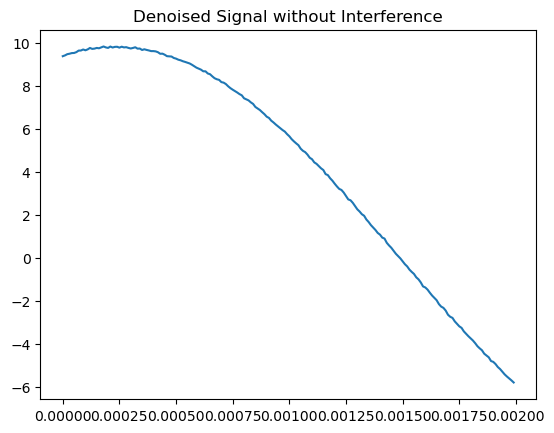

In [589]:
plt.plot(taxis[:200],np.real(np.fft.ifft(weighted_y,10000)[:200]))
plt.title('Denoised Signal without Interference')

# Part 4 : Come up with MVDR under interference signal

In [590]:
def mc_cov(X):
    # Reorganize as list in frequency of length M vector
    X = np.array(X)
    X = [X[:,f] for f in range(X.shape[-1])]
    
    C = [x.reshape(-1,1)@np.conj(x.reshape(-1,1)).T for x in X]
    
    # LIST OF channel-wise covariance per freq
    return C


# Interference Power spectral density
I_cov = mc_cov(Yi)

# Define new mixed signal
channel_y = [channel_s[m]+ channel_i[m] + np.random.normal(loc=0,scale=N_cov[m,m],size=channel_y[m].shape) for m in range(M)]

In [602]:
# Come up with RTF array for source (channel by freq)
def MVDR(g,Cv):
    g = np.array(g)
    W_freq = []
    for f in range(g.shape[-1]):
        gf = g[:,f].reshape(-1,1)
        num = np.linalg.pinv(Cv) @ gf
        den = np.conj(gf.T) @ num
        W_freq.append(num/den)
        
    output = np.array(W_freq).reshape(g.shape)
    return [output[i,:] for i in range(M)]

wmvdr = MVDR(np.conj(rtf_source),N_cov)

In [603]:
# Apply the MVDR filter
weighted_y = sum([scipy.fft.fft(y,10000)* w for y,w in zip(channel_y,wmvdr) ])

Text(0.5, 1.0, 'Before MVDR with Interference')

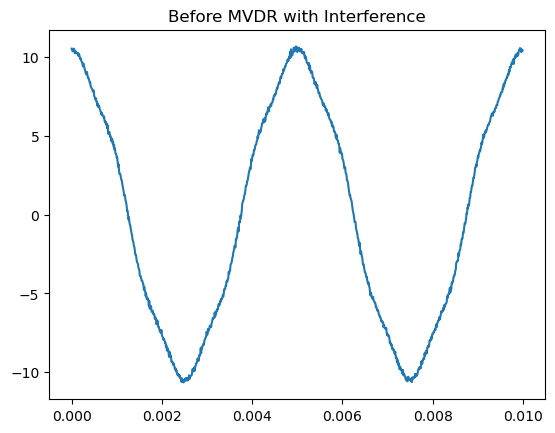

In [604]:
plt.plot(taxis[:1000],np.real(channel_y[0][:1000]))
plt.title('Before MVDR with Interference')



Text(0.5, 1.0, 'After MVDR with Interference')

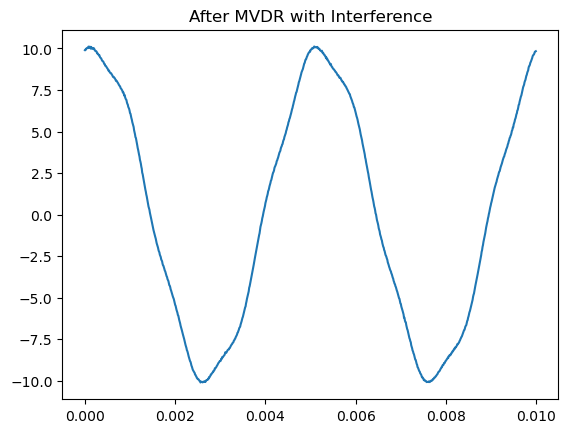

In [605]:
plt.plot(taxis[:1000],np.real(np.fft.ifft(weighted_y,10000))[:1000])
plt.title('After MVDR with Interference')



Text(0.5, 1.0, 'FFT of Output of MVDR with Interference')

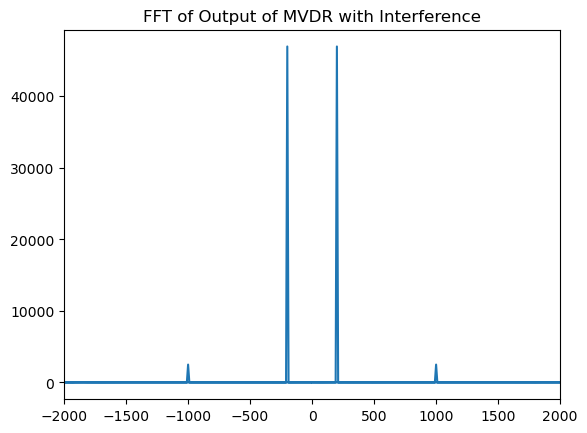

In [606]:
plt.plot(faxis,weighted_y)
plt.xlim([-2000,2000])
plt.title('FFT of Output of MVDR with Interference')



Text(0.5, 1.0, 'FFT input with Interference')

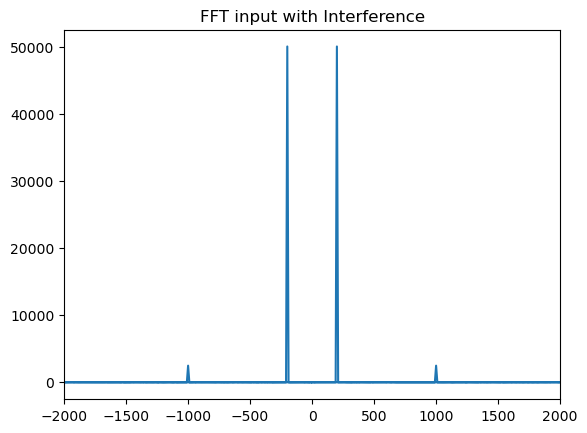

In [607]:
plt.plot(faxis,scipy.fft.fft(channel_y[0],10000))
plt.xlim([-2000,2000])
plt.title('FFT input with Interference')


# Part 5 : LCMV

In [608]:
def LCMV(g,d,Cv):
    
    # Rearrange for list in frequency  (channel by freq)
    g = np.array(g)
    d = np.array(d)
    lcmv = []
    for f in range(g.shape[-1]):
        gf = g[:,f].reshape(-1,1)
        df = d[:,f].reshape(-1,1)
        A = np.concatenate([gf,df],-1)
        u = np.array([1,0]).reshape(-1,1)
        
        num = np.linalg.inv(Cv) @ A
        den = np.conj(A.T) @ num 
        out = num @ np.linalg.pinv(den) @ u
        lcmv.append(out.flatten())
    
    # Reform into channel list of filter
    lcmv = np.array(lcmv)
    return [lcmv[:,m] for m in range(lcmv.shape[-1])]

lcmv_filt = LCMV(np.conj(rtf_source),np.conj(rtf_inter),N_cov)

In [609]:
# Apply the LCMV
weighted_y = sum([scipy.fft.fft(y,10000)* w  for y,w in zip(channel_y,lcmv_filt) ])

Text(0.5, 1.0, 'LCMV Output')

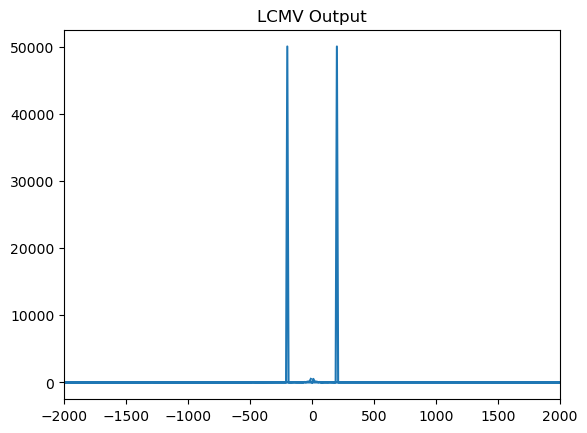

In [610]:
plt.plot(faxis,np.abs(weighted_y))
plt.xlim([-2000,2000])
plt.title('LCMV Output')

Text(0.5, 1.0, 'Reference Microphone')

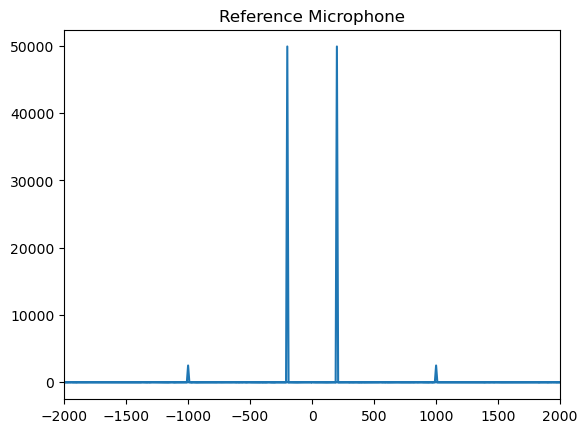

In [611]:
plt.plot(faxis,np.real(scipy.fft.fft(channel_y[1],10000)))
plt.xlim([-2000,2000])
plt.title('Reference Microphone')

# Part 6 : Evaluate Beamformer

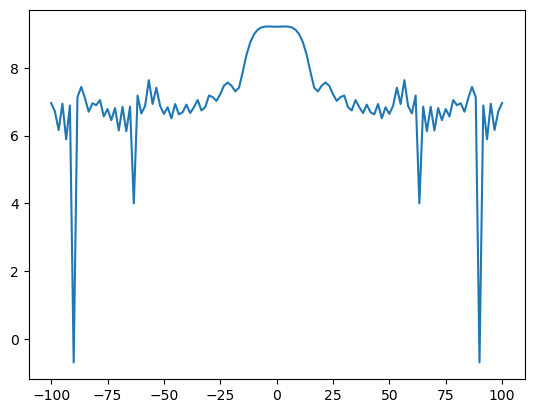

In [613]:
def beampattern(w,target_theta,angles,M,faxis,c,dL,ref_ch):
    output = []
    for a in angles:
        # Generate virtual RTF
        g = RTF_gen(a,M,faxis,c,dL,ref_ch)
        # Apply beamformer
        y = sum([np.sum(g[m]*w[m]) for m in range(M)])
        output.append(abs(np.sum(y)))
    
    return output
angles = np.linspace(-100, 100,121)
power = beampattern(lcmv_filt,10,angles,M,faxis,c,dL,ref_ch)
plt.plot(angles,np.log(power))